# Option pricing using Multi Level Monte Carlo method

We wish to evaluate the price of an Asian option:


$C = \mathbb E\left[e^{-rT}(\frac{1}{k}\sum_{i=1}^{k}S(t_i)-K)^+\right]$

## Question 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

### Brownian path generation

We consider the *CIR (Cow, Ingersoll, Ross) model* :

$dS_t = \alpha(b-S_t)\, dt + \sigma\sqrt{S_t}\, dW_t$

Discretization of the equation :

$S_{t+1} = S_{t} +\alpha(b-S_t)\Delta t+\sigma\epsilon\sqrt{S_t}$

In [3]:
def stock_path(S0, level, M=4):
    """
    Simulates a stock path according to the Euler discretization of the CIR model.
    
    INPUT:
        S0 (float): price of a stock at time 0. 
        level (int): level of discretization
        M (int): constant related to discretization
    
    OUTPUT:
        (array): stock path
    """
    h = T/np.power(M,level)
    dW = np.random.normal(size = np.power(M, level)//T)
    S = [S0]
    for i in range(np.power(M, level)//T):
        S_i = S[-1]+ a*(b-S[-1])*h + sigma*np.sqrt(max(S[-1], 0.0))*dW[i]*np.sqrt(h)
        S.append(S_i)
    return S

In [4]:
# Define model parameters

T=1
a, b, sigma, S0, K = 0.15, 0.2, 0.2, 5, 4
r=0.05

### Path samples

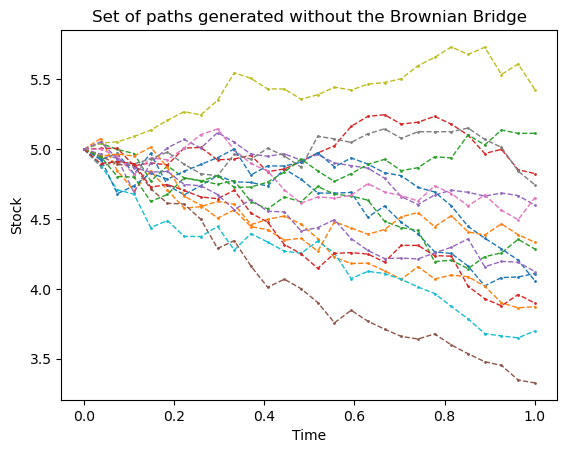

In [8]:
n_samples=15

for _ in range(n_samples):
  path = stock_path(S0, level=3, M=3)
  time_axis = np.linspace(0,T,len(path))
  plt.plot(time_axis, path, linewidth=1, linestyle='--', marker='o', markersize=1)

plt.title("Set of paths generated without the Brownian Bridge")
plt.ylabel('Stock') 
plt.xlabel('Time') 
plt.show()

In [5]:
def estimate_variance(f, level, N_l):
    """
    Returns the estimated variance according to the equation from the paper of Giles
    """

    fine_samples = [np.nan_to_num(f(stock_path(S0, level, M=4),K)) for _ in range(N_l)]   #computes N_l estimates of Pl_hat_i
    coarse_samples = [np.nan_to_num(f(stock_path(S0, level-1, M=4),K))
                      for _ in range(N_l)] if level > 0 else [0] * N_l                    #computes N_l estimates of P_{l-1}_hat_i
    diff_samples = np.array(fine_samples) - np.array(coarse_samples)                      #computes the terms of the telescopic sum
    return np.var(diff_samples)

In [6]:
def standard_monte_carlo(f, L, no_of_paths):
    """
        Function computing payoffs using standard Monte Carlo

    INPUT:
    f : function
        The function to be aproximated.

    OUTPUT:

    """
    payoffs = [np.nan_to_num(f(stock_path(S0, level=L, M=3),K)) for _ in range(no_of_paths)]
    return payoffs

In [7]:
def payoff_call(S, K):
    """
    Returns the payoff of the Asian Call option
    """
    return np.maximum(np.mean(S)-K, 0)* np.exp(-r * T)
    
def payoff_put(S, K):
    """
        Returns the payoff of the Asian Put option
    """
    return np.maximum(K-np.mean(S), 0)* np.exp(-r * T)

## Multi-Level MC Method

Basic idea (for $l=1$) :

$E\left[\hat{P_{1}}\right]=E\left[\hat{P_{0}}\right]+E\left[\hat{P_{1}}-\hat{P_{0}}\right]$

Estimator using a sequence of levels :

$\frac{1}{N_0}\sum_{n=1}^{N_0}\hat{P_{0}}^{(0, n)}+\sum_{l=1}^{L}\left[\frac{1}{N_l}\sum_{n=1}^{N_l}(\hat{P_{l}}^{(l, n)}-\hat{P}_{l-1}^{(l, n)})\right]$

In [8]:
import numpy as np

def mlmc(f, eps, M):
    """
    Multilevel Monte Carlo algorithm for computing E[f], where f is an expensive-to-evaluate function.
    
    Parameters:
    -----------
    f : function
        The function to be aproximated.
    L : int
        The number of levels of refinement.
    eps : float
        The desired accuracy of the estimator.
   
    
    Returns:
    --------
    P_0 : float
        The estimated value of f.
        
    V_L_hat : float
        The estimated variance of f.
    """
    L = 0
    converged = False
    V_L_sum = []
    
    Y_hat, V_L_hat = 0, 0
    P_0 = 0
    
    while not converged:
        
        V_L_sum = [estimate_variance(f, level=l, N_l=10**4) 
                   for l in range(L + 1)] #estimate variance to compute Nl
    
        
        hl = [T /np.power(M,l) for l in range(L + 1)]
        sum_sqrt_var_hl = sum([np.sqrt(V_L_sum[l] / hl[l]) for l in range(L + 1)])
    
        sample_sizes = [np.minimum(int(np.ceil(2 * (eps**-2) *
                                      np.sqrt(V_L_sum[l] * hl[l]) 
                                                * sum_sqrt_var_hl)),10**6) for l in range(L + 1)]
        
        if sample_sizes[L]==10**6:
            print("***** Maximum Number of Samples Is Achieved *****")
        
        
        print("Level:",L)
        print("Number of samples:",sample_sizes[L])
    
        if L<2:

            payoffs = []
            for _ in range(sample_sizes[L]):
                payoffs.append(f(stock_path(S0, level=L, M=4),K))

            Y_hat = np.mean(payoffs) # current level
            V_L_sum[L] = np.var(payoffs) #re-estimate the variance
            V_L_hat += V_L_sum[-1]/sample_sizes[L] # compute the total variance

            P_0 = Y_hat
            Y_l_1 = Y_hat
            L+=1

        elif L>=2 and not converged:
            
            payoffs = []
            payoffs_1 = []
            prod = 0
            for i in range(L):
                prod+=np.sqrt(V_L_sum[i]*T/np.power(M,i))


            for _ in range(sample_sizes[L]):
                S_L = stock_path(S0, level=L, M=4)
                S_L_1 = S_L[::M]
                payoffs.append(np.nan_to_num(f(S_L,K)))
                payoffs_1.append(np.nan_to_num(f(S_L_1,K)))

            Y_l_1 = np.mean(payoffs_1)  # coarser level   
            Y_hat = np.mean(payoffs) # current level
            P_0 += Y_hat-Y_l_1 # estimator
            V_L_sum[L] = np.var(payoffs) #re-estimate the variance
            V_L_hat += V_L_sum[-1]/sample_sizes[L] # compute the total variance

            if abs(Y_hat-Y_l_1)<1/np.sqrt(2)*(M**2-1)*eps:
                
                converged = True
                
            else:
                
                L+=1
                
        print("Payoff:", Y_hat)
        print("Variance:", V_L_hat)    

    return P_0, V_L_hat

In [9]:
a, b, sigma, S0, K = 0.15, 0.2, 0.3, 5, 4
comp_time = []
arr_res = []
cpu_time = 0
for m in range(3,25):
    for _ in range(10):
        start_time = time.process_time()
        arr_res.append(mlmc(f=payoff_call, eps=0.005, M=m))
        end_time = time.process_time()
        cpu_time += (end_time - start_time)
        print(cpu_time)
    comp_time.append(cpu_time/10)
    
    print("************************************************")
    print("Comutational time for M=:",m , cpu_time/10)
    cpu_time=0
    print("************************************************")
    print(arr_res[-1])

Level: 0
Number of samples: 7701
Payoff: 0.6107675772804717
Variance: 1.253506798375995e-05
Level: 1
Number of samples: 22551
Payoff: 0.627941963276766
Variance: 1.7206151890745262e-05
Level: 2
Number of samples: 30566
Payoff: 0.6262408353386395
Variance: 2.0792409949119407e-05
7.682170999999999
Level: 0
Number of samples: 7799
Payoff: 0.6209001025325753
Variance: 1.2276336041527555e-05
Level: 1
Number of samples: 22469
Payoff: 0.6220424388072806
Variance: 1.6959388402621952e-05
Level: 2
Number of samples: 30551
Payoff: 0.6287659342618326
Variance: 2.05440150273781e-05
14.945750999999998
Level: 0
Number of samples: 7696
Payoff: 0.6118996718684687
Variance: 1.2299818432006735e-05
Level: 1
Number of samples: 22139
Payoff: 0.6210838355284167
Variance: 1.704762467942566e-05
Level: 2
Number of samples: 30067
Payoff: 0.6278302962561475
Variance: 2.073335075608364e-05
22.214936999999995
Level: 0
Number of samples: 7770
Payoff: 0.6189886782352978
Variance: 1.2417826610219335e-05
Level: 1
Numbe

Payoff: 0.6243757368119995
Variance: 1.735244623912963e-05
Level: 2
Number of samples: 26763
Payoff: 0.627522864779809
Variance: 2.1473947158101505e-05
47.24193199999996
Level: 0
Number of samples: 7699
Payoff: 0.6097823284237152
Variance: 1.250531373671899e-05
Level: 1
Number of samples: 21384
Payoff: 0.6267448449204558
Variance: 1.7406219986694872e-05
Level: 2
Number of samples: 26994
Payoff: 0.629068129310245
Variance: 2.1465571178949507e-05
54.00999599999997
Level: 0
Number of samples: 7663
Payoff: 0.6115870846023164
Variance: 1.2502859784829466e-05
Level: 1
Number of samples: 20589
Payoff: 0.6283515607542124
Variance: 1.7608785709535538e-05
Level: 2
Number of samples: 27182
Payoff: 0.6262618617173509
Variance: 2.16315936936588e-05
60.84185099999999
Level: 0
Number of samples: 7758
Payoff: 0.6144884167542534
Variance: 1.2537299113213775e-05
Level: 1
Number of samples: 21226
Payoff: 0.6255903322978753
Variance: 1.7525921817955226e-05
Level: 2
Number of samples: 26638
Payoff: 0.62779

Level: 1
Number of samples: 20166
Payoff: 0.6227672717687099
Variance: 1.7541347022680913e-05
Level: 2
Number of samples: 24599
Payoff: 0.6266258245257846
Variance: 2.2039356040706998e-05
19.592152000000112
Level: 0
Number of samples: 7844
Payoff: 0.6130219398944138
Variance: 1.216397724168494e-05
Level: 1
Number of samples: 19916
Payoff: 0.6251186304952905
Variance: 1.7479355076321176e-05
Level: 2
Number of samples: 24425
Payoff: 0.6298755172596799
Variance: 2.1949007832481072e-05
26.102151000000106
Level: 0
Number of samples: 7649
Payoff: 0.6112785265265888
Variance: 1.2627636519986675e-05
Level: 1
Number of samples: 19791
Payoff: 0.6273595531795816
Variance: 1.800074926344962e-05
Level: 2
Number of samples: 24829
Payoff: 0.6263875410280173
Variance: 2.2397655234103265e-05
32.659788000000106
Level: 0
Number of samples: 7797
Payoff: 0.615162285041155
Variance: 1.2538951582613135e-05
Level: 1
Number of samples: 19965
Payoff: 0.6256060576498887
Variance: 1.7806788986360557e-05
Level: 2


Level: 2
Number of samples: 23636
Payoff: 0.6285053636134326
Variance: 2.2319414908228117e-05
57.90518299999985
Level: 0
Number of samples: 7769
Payoff: 0.6138544948684521
Variance: 1.269248320486412e-05
Level: 1
Number of samples: 19525
Payoff: 0.6233772382448424
Variance: 1.80493005704245e-05
Level: 2
Number of samples: 23273
Payoff: 0.6256557568657527
Variance: 2.2687440142284667e-05
64.3094719999998
************************************************
Comutational time for M=: 10 6.43094719999998
************************************************
(0.5039644639542424, 2.2687440142284667e-05)
Level: 0
Number of samples: 7741
Payoff: 0.6066974004994578
Variance: 1.2192106716575333e-05
Level: 1
Number of samples: 19284
Payoff: 0.6250319924658404
Variance: 1.7593433965334055e-05
Level: 2
Number of samples: 23401
Payoff: 0.6273216636103234
Variance: 2.222264207228492e-05
6.423253000000045
Level: 0
Number of samples: 7571
Payoff: 0.616160836277355
Variance: 1.270013692342594e-05
Level: 1
Number

Level: 1
Number of samples: 19158
Payoff: 0.6247660177701538
Variance: 1.790261395371168e-05
Level: 2
Number of samples: 22642
Payoff: 0.6262025343268611
Variance: 2.271719261343281e-05
31.69828199999995
Level: 0
Number of samples: 7934
Payoff: 0.611457979550981
Variance: 1.233980786707629e-05
Level: 1
Number of samples: 18778
Payoff: 0.6243841535080694
Variance: 1.7839744828470696e-05
Level: 2
Number of samples: 23012
Payoff: 0.6262209842366434
Variance: 2.2599540828987956e-05
38.03647999999987
Level: 0
Number of samples: 7595
Payoff: 0.6046538396390787
Variance: 1.2348600067490273e-05
Level: 1
Number of samples: 19140
Payoff: 0.6218999204777678
Variance: 1.7791034459998968e-05
Level: 2
Number of samples: 22510
Payoff: 0.6259010416697102
Variance: 2.2672478410411824e-05
44.33876999999984
Level: 0
Number of samples: 7599
Payoff: 0.6171332319691475
Variance: 1.2687049026509244e-05
Level: 1
Number of samples: 19569
Payoff: 0.622118392362238
Variance: 1.7959736930158262e-05
Level: 2
Numbe

Level: 0
Number of samples: 7708
Payoff: 0.609678007098393
Variance: 1.2577547653101345e-05
Level: 1
Number of samples: 18711
Payoff: 0.6217804360074142
Variance: 1.8190322325501295e-05
Level: 2
Number of samples: 22209
Payoff: 0.6256299407425393
Variance: 2.3101588571197545e-05
6.234303000000068
Level: 0
Number of samples: 7912
Payoff: 0.6122361693382897
Variance: 1.230609569487586e-05
Level: 1
Number of samples: 18823
Payoff: 0.6242966648373257
Variance: 1.785377415234176e-05
Level: 2
Number of samples: 22123
Payoff: 0.62743005059616
Variance: 2.27686609607108e-05
12.514234000000101
Level: 0
Number of samples: 7665
Payoff: 0.6167395953363888
Variance: 1.234110947239003e-05
Level: 1
Number of samples: 18982
Payoff: 0.6284203593500374
Variance: 1.7936910664592813e-05
Level: 2
Number of samples: 22527
Payoff: 0.627469712193817
Variance: 2.277698345486245e-05
18.829345000000103
Level: 0
Number of samples: 7689
Payoff: 0.6130268259912687
Variance: 1.268194204015358e-05
Level: 1
Number of 

Level: 1
Number of samples: 18458
Payoff: 0.6237722974094577
Variance: 1.811659701421319e-05
Level: 2
Number of samples: 21713
Payoff: 0.6241393094131356
Variance: 2.311579276712776e-05
43.667908000000125
Level: 0
Number of samples: 7836
Payoff: 0.614925740741692
Variance: 1.230207501570325e-05
Level: 1
Number of samples: 18944
Payoff: 0.622309284399522
Variance: 1.7775061653087968e-05
Level: 2
Number of samples: 22344
Payoff: 0.6264548220086421
Variance: 2.2729552639276374e-05
49.990475999999944
Level: 0
Number of samples: 7697
Payoff: 0.6092365123658605
Variance: 1.2193968982096494e-05
Level: 1
Number of samples: 18871
Payoff: 0.631635672880757
Variance: 1.7725600566396477e-05
Level: 2
Number of samples: 21559
Payoff: 0.6304343528277132
Variance: 2.283052198840819e-05
56.1999179999998
Level: 0
Number of samples: 7785
Payoff: 0.6125088659699772
Variance: 1.2420256459386144e-05
Level: 1
Number of samples: 18631
Payoff: 0.625526915585411
Variance: 1.803287184447452e-05
Level: 2
Number o

Level: 0
Number of samples: 7712
Payoff: 0.6034819879334196
Variance: 1.2454410540961123e-05
Level: 1
Number of samples: 18719
Payoff: 0.6218240823507164
Variance: 1.7995871062130364e-05
Level: 2
Number of samples: 21517
Payoff: 0.6270861289887388
Variance: 2.3107039010896592e-05
18.717462999999725
Level: 0
Number of samples: 7509
Payoff: 0.6134551844079198
Variance: 1.294038338473274e-05
Level: 1
Number of samples: 18738
Payoff: 0.6220971221017387
Variance: 1.859158353772869e-05
Level: 2
Number of samples: 21659
Payoff: 0.6334433380092404
Variance: 2.369990945477537e-05
24.96727199999964
Level: 0
Number of samples: 7759
Payoff: 0.6090755628683124
Variance: 1.245198453092902e-05
Level: 1
Number of samples: 18884
Payoff: 0.6230638270236694
Variance: 1.793769930902465e-05
Level: 2
Number of samples: 21020
Payoff: 0.6309756103896543
Variance: 2.3086769833626766e-05
31.198941999999533
Level: 0
Number of samples: 7832
Payoff: 0.6127864968764526
Variance: 1.2331783459287259e-05
Level: 1
Numb

Level: 1
Number of samples: 18824
Payoff: 0.6232518880180906
Variance: 1.8481781116313593e-05
Level: 2
Number of samples: 21188
Payoff: 0.624386107557394
Variance: 2.3653627363357494e-05
55.6312240000002
Level: 0
Number of samples: 7880
Payoff: 0.6113634974574911
Variance: 1.2545636358007534e-05
Level: 1
Number of samples: 18350
Payoff: 0.6211960101751557
Variance: 1.8191101970625522e-05
Level: 2
Number of samples: 21825
Payoff: 0.6288652064259933
Variance: 2.3201461337940536e-05
61.88531900000021
************************************************
Comutational time for M=: 23 6.1885319000000205
************************************************
(0.2988317921004351, 2.3201461337940536e-05)
Level: 0
Number of samples: 7656
Payoff: 0.6148287882274077
Variance: 1.2791775958803215e-05
Level: 1
Number of samples: 18287
Payoff: 0.6250261214790876
Variance: 1.8407463255493863e-05
Level: 2
Number of samples: 21382
Payoff: 0.6347774907844896
Variance: 2.3627763905453155e-05
6.2061489999998685
Level:

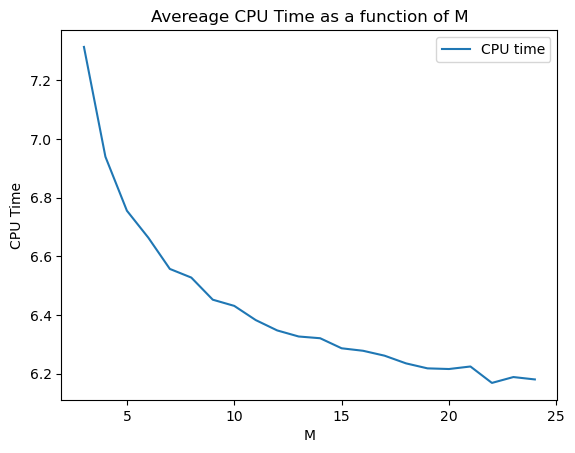

In [10]:
plt.plot(range(3,25),comp_time, label="CPU time")
plt.title('Avereage CPU Time as a function of M') 
plt.ylabel('CPU Time') 
plt.xlabel('M') 
plt.legend()
plt.show()

In [11]:
a, b, sigma, S0, K = 0.15, 0.2, 0.2, 5, 4
mc_res = standard_monte_carlo(f=payoff_call, L=3, no_of_paths=100000)

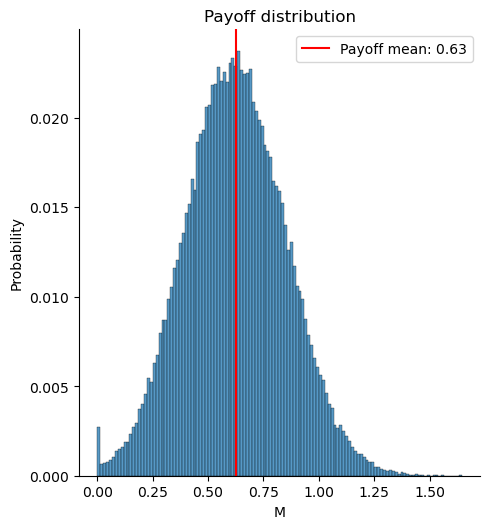

In [12]:
sns.displot(mc_res, stat='probability')
plt.title('Payoff distribution')
plt.xlabel('M')
payoff_mean=np.mean(mc_res)
plt.axvline(x=payoff_mean, color="red", label="Payoff mean: "+str(round(payoff_mean, 2)))
plt.legend()
plt.show()

In [13]:
np.mean(mc_res), np.var(mc_res)

(0.6250989091349114, 0.05120053961760971)

In [18]:
mlmc_cpu_time = 7.029
elapsed_time = 0

paths = 500

while elapsed_time < mlmc_cpu_time:
    start_time = time.process_time()
    mc_estimates = []
    for _ in range(100):
        mc_estimates.append(np.mean(standard_monte_carlo(f=payoff_call, L=3, no_of_paths=paths)))
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    print(paths)
    average_mc_price = np.mean(mc_estimates)
    mc_var = np.var(mc_estimates)
    print(mc_var, average_mc_price)
    paths+=100

average_mc_price = np.mean(mc_estimates)
mc_var = np.var(mc_estimates)

500
0.00010029259044366634 0.6237741637260656
600
8.702516597140215e-05 0.623222101959557
700
7.610977168784574e-05 0.6257464884236211
800
7.500837198245475e-05 0.6243231448915271


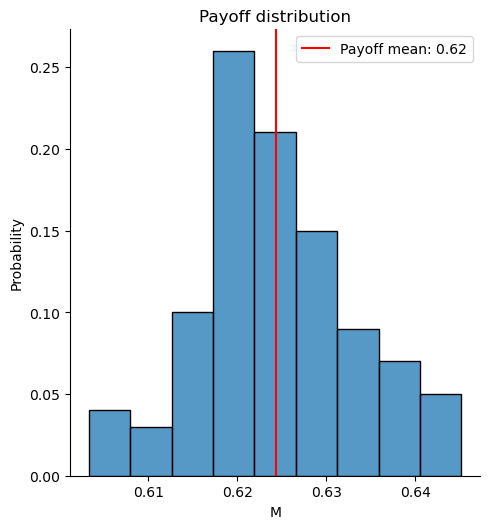

In [19]:
sns.displot(mc_estimates, stat='probability')
plt.title('Payoff distribution')
plt.xlabel('M')
payoff_mean=np.mean(mc_estimates)
plt.axvline(x=payoff_mean, color="red", label="Payoff mean: "+str(round(payoff_mean, 2)))
plt.legend()
plt.show()

In [16]:
mlmc_var = 2.107e-05
mc_var = 10**10

paths = 500
times = [] 
varis = []
while mlmc_var < mc_var:
    start_time = time.process_time()
    mc_estimates = []
    for _ in range(100):
        mc_estimates.append(np.mean(standard_monte_carlo(f=payoff_call, L=3, no_of_paths=paths)))
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    average_mc_price = np.mean(mc_estimates)
    mc_var = np.var(mc_estimates)
    times.append(elapsed_time)
    varis.append(mc_var)
    print(mc_var, average_mc_price)
    print(elapsed_time)
    paths+=100

0.0001080507572807492 0.6244449153769466
5.318866999999955
7.602429399801596e-05 0.6253736740306262
5.892552999999907
6.95045778631563e-05 0.6259273886233668
6.865506000000096
6.922136545099632e-05 0.6251349164957294
7.781479999999874
4.7095056078126655e-05 0.6247604435854305
8.590089999999918
5.0699265173385756e-05 0.624373214417044
9.670765000000074
3.860049310972764e-05 0.6246535502271598
10.74781999999982
4.45168896218344e-05 0.6237620116994198
11.74155699999983
3.95337340042096e-05 0.6255529843513021
12.518417
3.300560666061705e-05 0.6251179824157185
13.715805000000046
3.063336882113908e-05 0.6247669198300168
14.529119000000037
3.588554161857695e-05 0.6247256878005024
15.308009000000084
3.0023408104855354e-05 0.6255475121170155
16.227300000000014
3.043918679907298e-05 0.6243447499041398
17.25272599999994
3.490905634133967e-05 0.6260408667491845
17.868300999999974
2.5806153905592463e-05 0.6249736711963039
19.201773999999887
2.4543697558430504e-05 0.6246161434861532
20.1009039999999

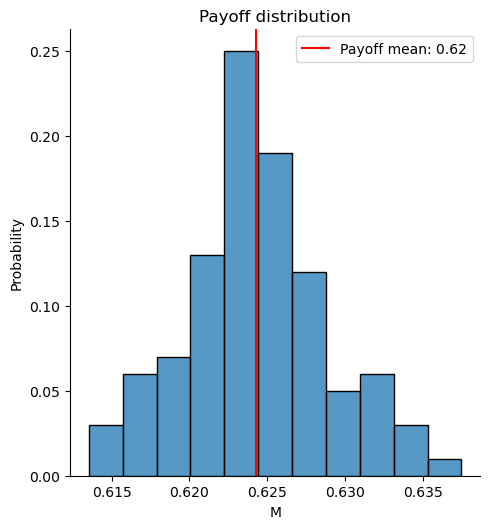

In [17]:
sns.displot(mc_estimates, stat='probability')
plt.title('Payoff distribution')
plt.xlabel('M')
payoff_mean=np.mean(mc_estimates)
plt.axvline(x=payoff_mean, color="red", label="Payoff mean: "+str(round(payoff_mean, 2)))
plt.legend()
plt.show()